In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import preprocessing

C:\Users\ejohn\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Read in Salary Dataset
players_df = pd.read_csv('PlayerSalaries_v2.csv')

players_df = players_df.drop('Unnamed: 0', axis=1)
players_df = players_df[['Player', 'Team', 'Year', 'Pos', 'Height', 'Exp', 'OWS', 'DWS', 'WS', 'WS_Per_48', 'Salary']]

players_df.head()

,Player,Team,Year,Pos,Height,Exp,OWS,DWS,WS,WS_Per_48,Salary
0,Danny Ainge,BOS,1985,SG,6-4,3,3.9,2.8,6.7,0.124,400000
1,Larry Bird,BOS,1985,SF,6-9,5,10.5,5.2,15.7,0.238,1800000
2,Quinn Buckner,BOS,1985,PG,6-3,8,0.0,1.2,1.2,0.027,239000
3,M.L. Carr,BOS,1985,SF,6-6,9,0.0,0.5,0.5,0.050,175000
4,Carlos Clark,BOS,1985,SG,6-4,1,0.0,0.7,0.7,0.044,65000


In [3]:
def feet_to_inches(feet):
    return int(feet[0])*12 + int(feet[2:])

In [4]:
# Convert Height to Inches
players_df['Height'] = players_df['Height'].apply(lambda x: feet_to_inches(x))

# Convert 'R's in 'Exp' to 0
players_df['Exp'] = players_df['Exp'].apply(lambda x: 0 if x=='R' else int(x))
players_df.head()

,Player,Team,Year,Pos,Height,Exp,OWS,DWS,WS,WS_Per_48,Salary
0,Danny Ainge,BOS,1985,SG,76,3,3.9,2.8,6.7,0.124,400000
1,Larry Bird,BOS,1985,SF,81,5,10.5,5.2,15.7,0.238,1800000
2,Quinn Buckner,BOS,1985,PG,75,8,0.0,1.2,1.2,0.027,239000
3,M.L. Carr,BOS,1985,SF,78,9,0.0,0.5,0.5,0.050,175000
4,Carlos Clark,BOS,1985,SG,76,1,0.0,0.7,0.7,0.044,65000


In [5]:
# Drop Salary Outliers
players_df = players_df[players_df['Salary']!=0]
players_df.describe()

,Year,Height,Exp,OWS,DWS,WS,WS_Per_48,Salary
count,12887.000000,12887.000000,12887.00000,12887.000000,12887.000000,12887.000000,12887.000000,1.288700e+04
mean,2003.604252,79.082874,4.64018,1.659486,1.349593,3.009079,0.095056,3.225124e+06
std,9.209740,3.685185,3.95623,2.063694,1.264004,3.030774,0.070994,4.233748e+06
min,1985.000000,63.000000,0.00000,0.000000,0.000000,0.000000,0.000000,4.608000e+03
25%,1996.000000,77.000000,1.00000,0.200000,0.300000,0.700000,0.053000,6.500000e+05
50%,2004.000000,80.000000,4.00000,0.900000,1.000000,2.100000,0.090000,1.528440e+06
75%,2011.000000,82.000000,7.00000,2.400000,2.000000,4.400000,0.126000,4.000000e+06
max,2018.000000,91.000000,20.00000,15.200000,9.100000,21.300000,2.712000,3.468255e+07


In [6]:
dict_list = []

# Start at 1988 because salary data not available before 1985, and not in 1987
for year in range(1992, np.max(players_df.Year)+1):
    for pos in players_df.Pos.unique():
        
        # Query by Psotion, by Year
        query = players_df[np.logical_and(players_df['Year']==year, players_df['Pos']==pos)]
        
        # Aggregate Height, Experience, Salary
        mean_ht = np.mean(query['Height'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_sal = np.mean(query['Salary'])
        mean_exp = np.mean(query['Exp'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_Height': mean_ht, 'Mean_Exp': mean_exp, 'Mean_Salary': mean_sal}
        
        dict_list.append(d)
        
sal_by_year = pd.DataFrame(data=dict_list)
sal_by_year.head()

,Mean_Exp,Mean_Height,Mean_Salary,Pos,Year
0,3.928571,76.642857,8.496286e+05,SG,1992
1,4.190476,79.190476,1.013127e+06,SF,1992
2,4.117647,73.426471,8.545000e+05,PG,1992
3,5.013889,83.722222,1.163194e+06,C,1992
4,3.863014,81.164384,1.073562e+06,PF,1992


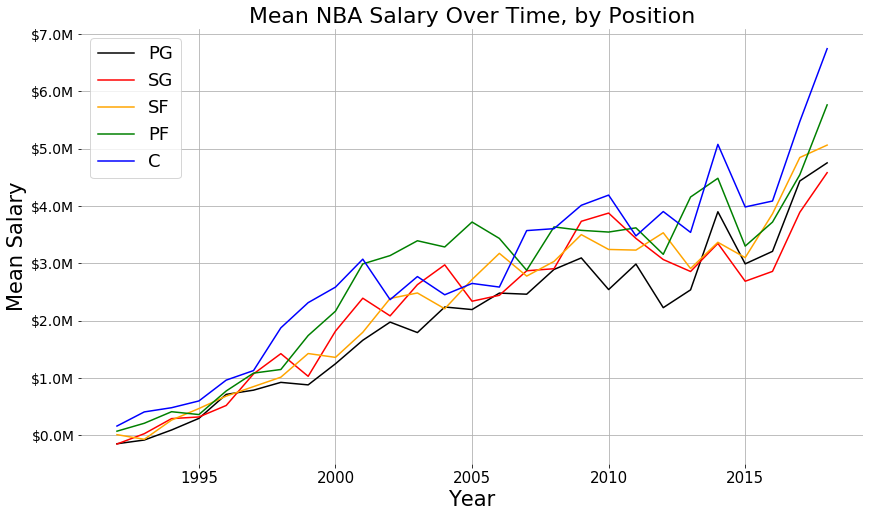

In [8]:
fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(sal_by_year[sal_by_year['Pos']==pos].Year, sal_by_year[sal_by_year['Pos']==pos].Mean_Salary, color=colors[i], label=pos)
    
ax.set_xlabel('Year', fontsize=21)
ax.set_ylabel('Mean Salary', fontsize=21)
ax.set_title('Mean NBA Salary Over Time, by Position', fontsize=22)

labels = ['$' + str(n) + '.0M' for n in range(-1,9)]
ax.set_yticklabels(labels)

plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)    

ax.legend(prop={'size': 18})
plt.grid()
plt.savefig('MeanSalaries.png')
plt.show()

In [9]:
# Count the Amount of Players by Position Over the Years

d = {}
dict_list = []
for p in ['PG', 'SG', 'SF', 'PF', 'C']:
    d = {}
    for year in range(1985, 2019):
        d['Pos'] = p
        d['{}'.format(year)] = len(players_df[np.logical_and(players_df.Pos==p, players_df.Year==year)])
        
    dict_list.append(d)
    
pos_counts = pd.DataFrame(data=dict_list).set_index('Pos')
pos_counts

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Pos,,,,,,,,,,,,,,,,,,,,,
PG,35,51,0,52,58,7,68,68,66,68,...,83,88,76,81,76,64,94,102,103,99
SG,39,54,0,61,56,10,65,70,67,64,...,86,82,94,88,91,78,104,99,107,119
SF,43,61,0,60,59,11,64,63,68,59,...,80,86,92,89,96,73,86,94,88,81
PF,44,60,0,56,65,14,78,73,83,79,...,89,86,79,94,90,79,107,106,104,93
C,45,61,0,67,73,22,73,72,72,76,...,94,89,101,90,91,72,85,92,98,103


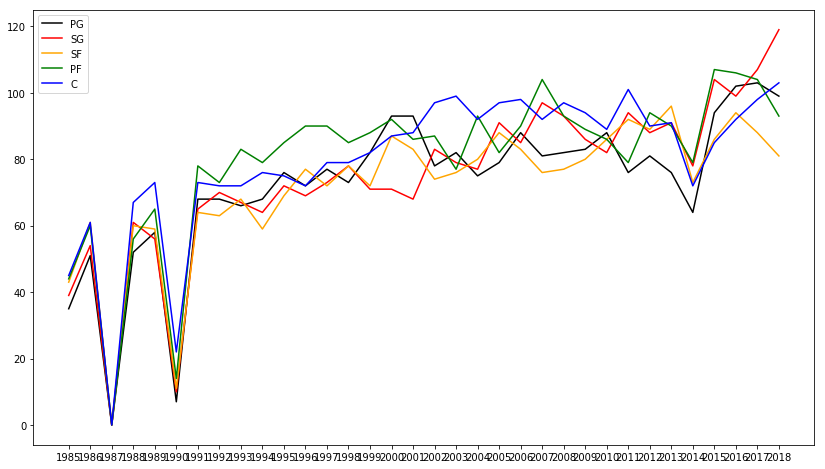

In [10]:
fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(pos_counts.columns, pos_counts.iloc[i], color=colors[i], label=pos)
    
ax.legend()    
plt.show()

In [11]:
# Make dataset of just players 11-15
bottom_roster_df = pd.DataFrame()

for year in range(1985, 2019):
    
    # Restrict DF to a Year
    year_df = players_df[players_df['Year']==year]
    
    for team in players_df['Team'].unique():
        
        # Restrict DF to a Team
        team_df = year_df[year_df['Team'] == team]
        
        # Run for Every Player in 11-15 Range
        for n in range(team_df.shape[0]-10):
        
            # Get Index of Least Contributing Player
            temp_min_index = team_df['WS'].values.argmin()
            
            # Add Player to Bottom_Roster
            bottom_roster_df = bottom_roster_df.append(team_df.iloc[temp_min_index])
            
            # Remove Player from the DF, Repeat
            team_df = team_df.reset_index(drop=True)
            team_df = team_df.drop(temp_min_index)
            
bottom_roster_df['Year'] = bottom_roster_df['Year'].astype(int)
bottom_roster_df.head(15)

,DWS,Exp,Height,OWS,Player,Pos,Salary,Team,WS,WS_Per_48,Year
6,0.4,1.0,83.0,0.0,Greg Kite,C,120000.0,BOS,0.4,0.006,1985
14,0.1,2.0,80.0,0.1,Marc Iavaroni,PF,100000.0,PHI,0.2,0.124,1985
62,0.5,5.0,81.0,0.2,Major Jones,PF,65000.0,DET,0.7,0.081,1985
8,0.4,2.0,77.0,0.6,Brook Steppe,SG,100000.0,DET,1.0,0.097,1985
148,0.0,10.0,78.0,0.1,Billy Knight,SG,433000.0,KCK,0.1,0.021,1985
160,0.3,4.0,74.0,0.0,Ronnie Lester,PG,244000.0,LAL,0.3,0.039,1985
10,0.5,10.0,78.0,0.3,Jamaal Wilkes,SF,860000.0,LAL,0.8,0.056,1985
182,0.1,6.0,83.0,0.0,Rick Robey,C,425000.0,PHO,0.1,0.037,1985
208,0.9,1.0,77.0,0.0,Rick Carlisle,SG,90000.0,BOS,0.9,0.056,1986
8,0.6,0.0,74.0,0.5,Sam Vincent,SG,87500.0,BOS,1.1,0.037,1986


In [12]:
# Make dataset of just players 1-10
top_roster_df = pd.DataFrame()

for year in range(1985, 2019):
    
    # Restrict DF to a Year
    year_df = players_df[players_df['Year']==year]
    
    for team in players_df['Team'].unique():
        
        # Restrict DF to a Team
        team_df = year_df[year_df['Team'] == team]
        
        if team_df.shape[0] <= 10: nruns = team_df.shape[0]
        else: nruns = 10
        
        # Run for Every Player in 11-15 Range
        for n in range(nruns):
        
            # Get Index of Least Contributing Player
            temp_max_index = team_df['WS'].values.argmax()
            
            # Add Player to Bottom_Roster
            top_roster_df = top_roster_df.append(team_df.iloc[temp_max_index])
            
            # Remove Player from the DF, Repeat
            team_df = team_df.reset_index(drop=True)
            team_df = team_df.drop(temp_max_index)
            
top_roster_df['Year'] = top_roster_df['Year'].astype(int)
top_roster_df.head(15)

,DWS,Exp,Height,OWS,Player,Pos,Salary,Team,WS,WS_Per_48,Year
1,5.2,5.0,81.0,10.5,Larry Bird,SF,1800000.0,BOS,15.7,0.238,1985
8,3.4,4.0,82.0,7.6,Kevin McHale,PF,1000000.0,BOS,11.0,0.199,1985
8,4.0,8.0,84.0,5.0,Robert Parish,C,700000.0,BOS,9.0,0.151,1985
0,2.8,3.0,76.0,3.9,Danny Ainge,SG,400000.0,BOS,6.7,0.124,1985
4,2.8,8.0,76.0,3.5,Dennis Johnson,PG,405000.0,BOS,6.3,0.103,1985
5,1.4,7.0,80.0,3.2,Cedric Maxwell,SF,830000.0,BOS,4.6,0.147,1985
5,1.0,10.0,79.0,1.2,Scott Wedman,SF,400000.0,BOS,2.2,0.093,1985
0,1.2,8.0,75.0,0.0,Quinn Buckner,PG,239000.0,BOS,1.2,0.027,1985
2,0.7,1.0,76.0,0.0,Carlos Clark,SG,65000.0,BOS,0.7,0.044,1985
0,0.5,9.0,78.0,0.0,M.L. Carr,SF,175000.0,BOS,0.5,0.050,1985


In [13]:
# Count the Amount of Players at the Bottom of the Roster by Position Over the Years
d = {}
dict_list = []
for p in ['PG', 'SG', 'SF', 'PF', 'C']:
    d = {}
    for year in range(1985, 2019):
        d['Pos'] = p
        d['{}'.format(year)] = len(bottom_roster_df[np.logical_and(bottom_roster_df.Pos==p, bottom_roster_df.Year==year)])
        
    dict_list.append(d)
    
pos_counts = pd.DataFrame(data=dict_list).set_index('Pos')
pos_counts

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Pos,,,,,,,,,,,,,,,,,,,,,
PG,1,10,0,12,11,0,17,18,13,15,...,26,26,22,28,27,9,40,50,44,44
SG,2,10,0,18,10,0,14,20,21,11,...,29,26,28,26,30,17,43,37,48,53
SF,1,12,0,14,14,0,15,10,12,11,...,20,26,32,29,39,15,32,38,34,39
PF,2,11,0,10,11,0,17,11,22,19,...,34,27,25,22,18,14,38,38,44,28
C,2,14,0,12,15,0,15,17,18,20,...,23,26,35,37,30,13,23,30,30,31


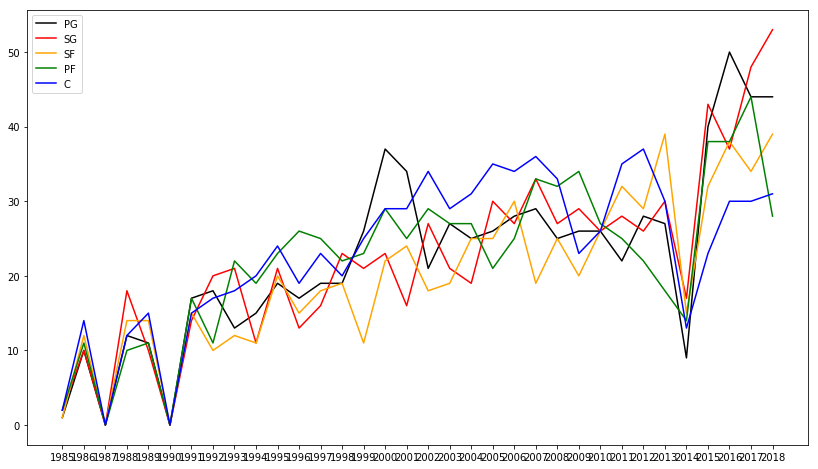

In [14]:
fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(pos_counts.columns, pos_counts.iloc[i], color=colors[i], label=pos)
    
ax.legend()    
plt.show()

In [16]:
dict_list = []

# Start at 1988 because salary data not available before 1985, and not in 1987
for year in range(1992, np.max(bottom_roster_df.Year)+1):
    for pos in bottom_roster_df.Pos.unique():
        
        # Query by Psotion, by Year
        query = bottom_roster_df[np.logical_and(bottom_roster_df['Year']==year, bottom_roster_df['Pos']==pos)]
        
        # Aggregate Height, Experience, Salary
        mean_ht = np.mean(query['Height'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_sal = np.mean(query['Salary'])
        mean_exp = np.mean(query['Exp'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_Height': mean_ht, 'Mean_Exp': mean_exp, 'Mean_Salary': mean_sal}
        
        dict_list.append(d)
        
sal_by_year = pd.DataFrame(data=dict_list)
sal_by_year.head()

,Mean_Exp,Mean_Height,Mean_Salary,Pos,Year
0,3.941176,83.411765,578941.176471,C,1992
1,2.818182,80.818182,744000.000000,PF,1992
2,2.650000,76.250000,432100.000000,SG,1992
3,4.055556,74.166667,459500.000000,PG,1992
4,2.000000,78.400000,536000.000000,SF,1992


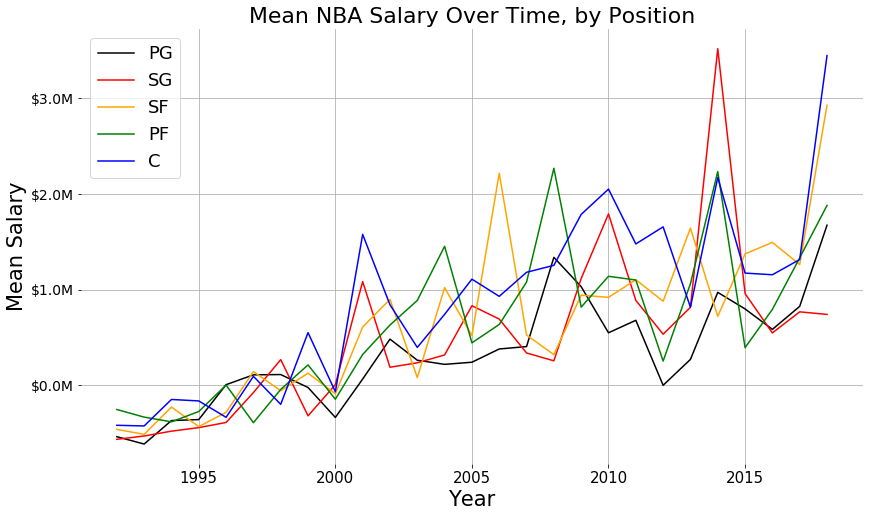

In [17]:
fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(sal_by_year[sal_by_year['Pos']==pos].Year, sal_by_year[sal_by_year['Pos']==pos].Mean_Salary, color=colors[i], label=pos)
    
ax.set_xlabel('Year', fontsize=21)
ax.set_ylabel('Mean Salary', fontsize=21)
ax.set_title('Mean NBA Salary Over Time, by Position', fontsize=22)

labels = ['$' + str(n) + '.0M' for n in range(-1,9)]
ax.set_yticklabels(labels)

plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)    

ax.legend(prop={'size': 18})
plt.grid()
#plt.savefig('MeanSalaries.png')
plt.show()

In [18]:
#### How big is the difference betweeen Centers' salaries and guards? ####

# Standardize Salaries by Year, Re-Run Mean Plot

dict_list = []

# Start at 1988 because salary data not available before 1985, and not in 1987
for year in range(1992, np.max(players_df.Year)+1):
    
    # Standardize Height, Salaries
    year_query = players_df[players_df['Year']==year]

    year_query['Salary'] = (year_query['Salary']-np.mean(year_query['Salary']))/np.std(year_query['Salary'])
    year_query['Height'] = (year_query['Height']-np.mean(year_query['Height']))/np.std(year_query['Height'])
    
    for pos in players_df.Pos.unique():
        
        # Query by Position, by Year
        query = year_query[year_query['Pos']==pos]
        
        # Aggregate Height, Experience, Salary
        mean_ht = np.mean(query['Height'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_sal = np.mean(query['Salary'])
        mean_exp = np.mean(query['Exp'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_Height': mean_ht, 'Mean_Exp': mean_exp, 'Mean_Salary': mean_sal}
        
        dict_list.append(d)
        
sal_by_year = pd.DataFrame(data=dict_list)
sal_by_year.head()

C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Mean_Exp,Mean_Height,Mean_Salary,Pos,Year
0,3.928571,-0.567874,-0.177860,SG,1992
1,4.190476,0.072589,0.025177,SF,1992
2,4.117647,-1.376463,-0.171811,PG,1992
3,5.013889,1.211855,0.211536,C,1992
4,3.863014,0.568823,0.100227,PF,1992


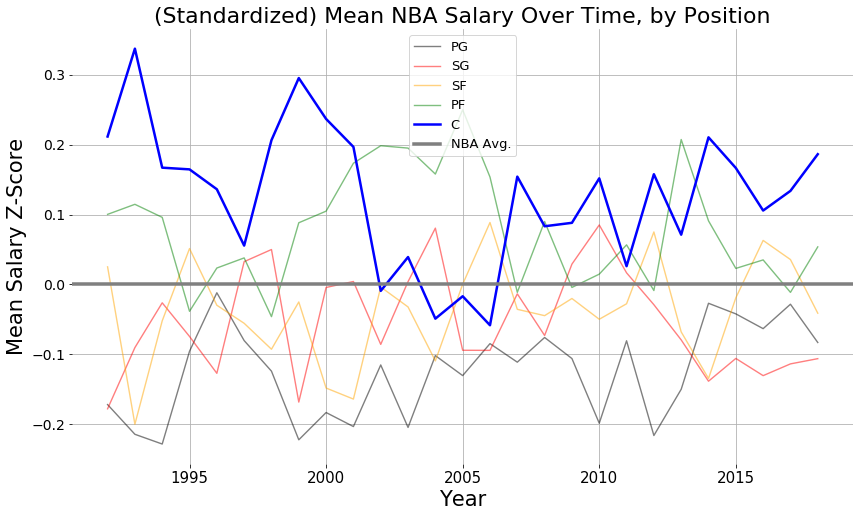

In [19]:
fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']
alphas = [0.5, 0.5, 0.5, 0.5, 1.0]
linewidths = [1.4, 1.4, 1.4, 1.4, 2.5]

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(sal_by_year[sal_by_year['Pos']==pos].Year, sal_by_year[sal_by_year['Pos']==pos].Mean_Salary, color=colors[i], alpha=alphas[i], linewidth=linewidths[i], label=pos)
    
ax.axhline(y=0, color='grey', linewidth=3.5, label='NBA Avg.')

ax.set_xlabel('Year', fontsize=21)
ax.set_ylabel('Mean Salary Z-Score', fontsize=21)
ax.set_title('(Standardized) Mean NBA Salary Over Time, by Position', fontsize=22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=14)    

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)    

ax.legend(prop={'size': 13}, loc='upper center')
plt.grid()
#plt.savefig('MeanSalariesStandardized.png')
plt.show()

In [20]:
# Get P-Values for 2018:
centers_2018 = players_df[np.logical_and(players_df['Pos']=='C', players_df['Year']==2018)]
non_centers_2018 = players_df[np.logical_and(players_df['Pos']!='C', players_df['Year']==2018)]

print('Average Experience of Centers (in years):', np.mean(centers_2018['Exp']))
print('Average Experience of Non-Centers (in years):', np.mean(non_centers_2018['Exp']))

sp.stats.ttest_ind(centers_2018['Salary'], non_centers_2018['Salary'])

Average Experience of Centers (in years): 5.310679611650485
Average Experience of Non-Centers (in years): 4.38265306122449


Ttest_indResult(statistic=2.1296841765394361, pvalue=0.033692407885729102)

In [21]:
def build_model_design(df, n=4):

    # get continuous variables
    cont_predictors = df[['Height']].copy()
    
    # convert to numpy array
    design_mat = df.values

    # degree 4 polynomials
    transformer_ = PolynomialFeatures(n, include_bias=False)
    
    # for each continuous predictor
    for predictor in cont_predictors:

        # append new polynomial predictors to the design matrix
        new_predictors = transformer_.fit_transform(
        cont_predictors[predictor].values.reshape(-1, 1))[:,1:]
        design_mat = np.concatenate([design_mat, new_predictors], axis=1)
    
    # add the names of new predictors to list of columns
    new_cols = []
    for i in range(len(cont_predictors.columns)):
        for j in range(n-1):
            new_cols = new_cols + [cont_predictors.columns[i] + str(j+2)]
                
    cols = list(df.columns) + new_cols

    # recreate DataFrame with new predictors
    design_df = pd.DataFrame(data=design_mat, index = range(len(design_mat)), columns=cols)

    return design_df

def get_poly_prediction(model, x):
    
    # Add Intercept
    pred = model.intercept_
    
    # Apply Coefficients
    for i in range(len(model.coef_)):
        pred = pred + (x**(i+1))*model.coef_[i]
    
    return pred


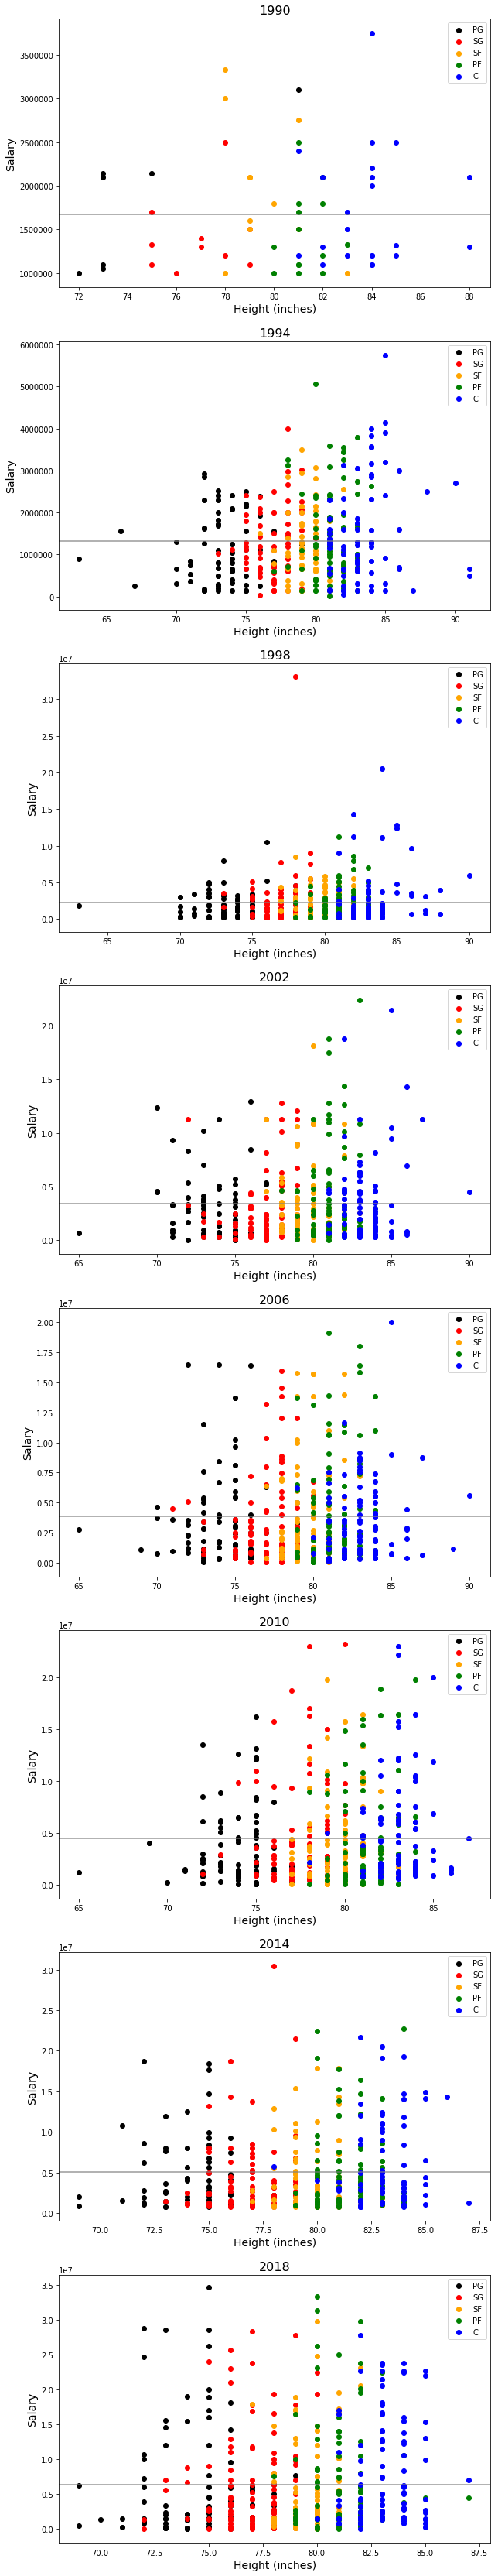

In [22]:
fig, axes = plt.subplots(len(np.arange(1990, 2019, 4)), 1, figsize=(10,60))

for y, year in enumerate(np.arange(1990, 2019, 4)):
    
    year_df = players_df[players_df['Year']==year]
    X_year = year_df[['Height']]
    Y_year = year_df['Salary']

    mean_sal = np.mean(Y_year)
    
    for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
        
        
        df = year_df[year_df['Pos']==pos]
        X = df[['Height']]
        Y = df['Salary']
                
        axes[y].scatter(X, Y, color = colors[i], label=pos)
        
    # Build Degree 4 Design Matrix
    X_design = build_model_design(X_year, 1)

    # Fit Regression
    poly_reg = LinearRegression()
    poly_reg.fit(X_design, Y_year)
    
    # Plot Regression
    prediction_line = [get_poly_prediction(poly_reg, x) for x in np.linspace(np.min(X), np.max(X), 500)]
    #axes[y].plot(np.linspace(np.min(X_year), np.max(X_year), 500), prediction_line)
    
    axes[y].axhline(y=mean_sal, linewidth=2, color='grey', alpha=0.6)
    
    axes[y].set_title(str(year), fontsize=16)
    axes[y].set_xlabel('Height (inches)', fontsize=14)
    axes[y].set_ylabel('Salary', fontsize=14)
    
    axes[y].legend()
    
plt.savefig('Height_Salary_Scatter.png')
plt.show()

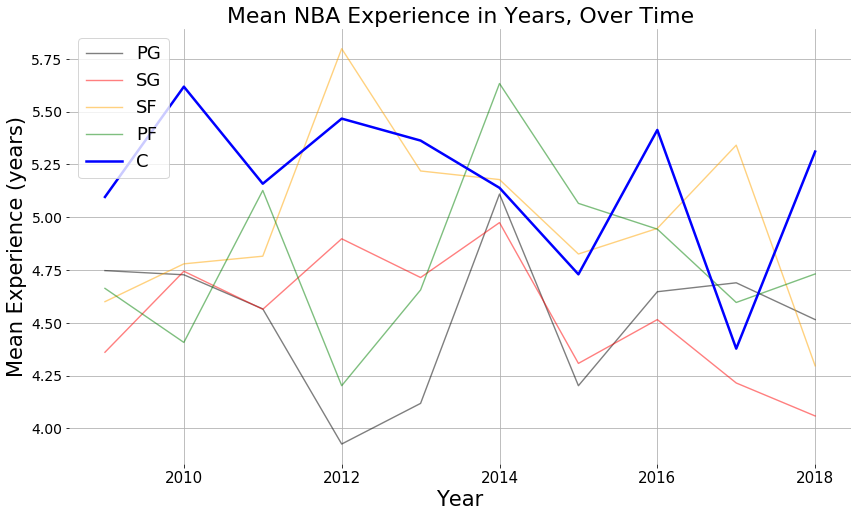

In [23]:
dict_list = []

# Start at 1988 because salary data not available before 1985, and not in 1987
for year in range(2009, np.max(players_df.Year)+1):
    for pos in players_df.Pos.unique():
        
        # Query by Psotion, by Year
        query = players_df[np.logical_and(players_df['Year']==year, players_df['Pos']==pos)]
        
        # Aggregate Height, Experience, Salary
        mean_ht = np.mean(query['Height'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_sal = np.mean(query['Salary'])
        mean_exp = np.mean(query['Exp'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_Height': mean_ht, 'Mean_Exp': mean_exp, 'Mean_Salary': mean_sal}
        
        dict_list.append(d)
        
sal_by_year = pd.DataFrame(data=dict_list)

fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']
alphas = [0.5, 0.5, 0.5, 0.5, 1.0]
linewidths = [1.4, 1.4, 1.4, 1.4, 2.5]

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(sal_by_year[sal_by_year['Pos']==pos].Year, sal_by_year[sal_by_year['Pos']==pos].Mean_Exp, color=colors[i], alpha=alphas[i], linewidth=linewidths[i], label=pos)    

ax.set_xlabel('Year', fontsize=21)
ax.set_ylabel('Mean Experience (years)', fontsize=21)
ax.set_title('Mean NBA Experience in Years, Over Time', fontsize=22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)    

ax.legend(prop={'size': 18})
plt.grid()
plt.savefig('MeanExperience.png')
plt.show()

C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

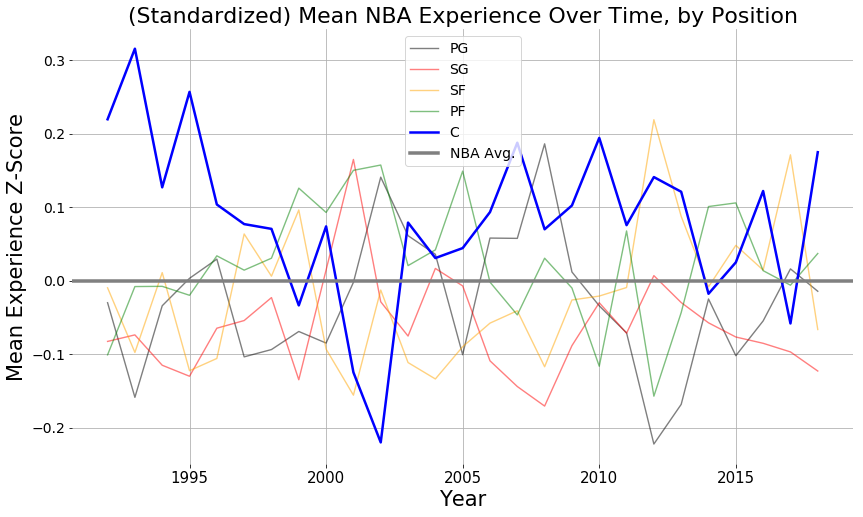

In [25]:
# Standardize Salaries by Year, Re-Run Mean Plot

dict_list = []

# Start at 1988 because salary data not available before 1985, and not in 1987
for year in range(1992, np.max(players_df.Year)+1):
    
    # Standardize Height, Salaries
    year_query = players_df[players_df['Year']==year]

    year_query['Salary'] = (year_query['Salary']-np.mean(year_query['Salary']))/np.std(year_query['Salary'])
    year_query['Height'] = (year_query['Height']-np.mean(year_query['Height']))/np.std(year_query['Height'])
    year_query['Exp'] = (year_query['Exp']-np.mean(year_query['Exp']))/np.std(year_query['Exp'])
    
    for pos in players_df.Pos.unique():
        
        # Query by Position, by Year
        query = year_query[year_query['Pos']==pos]
        
        # Aggregate Height, Experience, Salary
        mean_ht = np.mean(query['Height'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_sal = np.mean(query['Salary'])
        mean_exp = np.mean(query['Exp'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_Height': mean_ht, 'Mean_Exp': mean_exp, 'Mean_Salary': mean_sal}
        
        dict_list.append(d)
        
sal_by_year = pd.DataFrame(data=dict_list)

# Plot it!

fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']
alphas = [0.5, 0.5, 0.5, 0.5, 1.0]
linewidths = [1.4, 1.4, 1.4, 1.4, 2.5]

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(sal_by_year[sal_by_year['Pos']==pos].Year, sal_by_year[sal_by_year['Pos']==pos].Mean_Exp, color=colors[i], alpha=alphas[i], linewidth=linewidths[i], label=pos)
    
ax.axhline(y=0, color='grey', linewidth=3.5, label='NBA Avg.')

ax.set_xlabel('Year', fontsize=21)
ax.set_ylabel('Mean Experience Z-Score', fontsize=21)
ax.set_title('(Standardized) Mean NBA Experience Over Time, by Position', fontsize=22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)    

ax.legend(prop={'size': 14})
plt.grid()
plt.savefig('MeanExpStandardized.png')
plt.show()

In [26]:
# Test P-Val of Experience of Centers vs. Non-Centers
centers_2018 = players_df[np.logical_and(players_df['Pos']=='C', players_df['Year']==2018)]
non_centers_2018 = players_df[np.logical_and(players_df['Pos']!='C', players_df['Year']==2018)]

sp.stats.ttest_ind(centers_2018['Exp'], non_centers_2018['Exp'])

Ttest_indResult(statistic=1.997176754371649, pvalue=0.046355158328476642)

In [27]:
players_df[np.logical_and(players_df['Year']==2018, players_df['Pos']=='C')].sort_values(by=['Salary'], ascending=False)

,Player,Team,Year,Pos,Height,Exp,OWS,DWS,WS,WS_Per_48,Salary
12416,Al Horford,BOS,2018,C,82,10,4.0,3.8,7.8,0.165,27734405
12543,Andre Drummond,DET,2018,C,83,5,4.6,5.7,10.3,0.189,23775506
12501,Hassan Whiteside,MIA,2018,C,84,5,2.3,3.0,5.3,0.187,23775506
12564,Dwight Howard,CHO,2018,C,83,13,2.9,3.9,6.8,0.132,23500000
12840,DeAndre Jordan,LAC,2018,C,83,9,6.0,3.4,9.4,0.186,22642350
12916,Marc Gasol,MEM,2018,C,85,9,1.5,2.6,4.1,0.080,22642350
12865,Brook Lopez,LAL,2018,C,84,9,1.9,1.9,3.8,0.105,22642350
12458,Kevin Love,CLE,2018,C,82,9,4.7,1.6,6.3,0.185,22642350
12729,Steven Adams,OKC,2018,C,84,4,6.7,3.0,9.7,0.187,22471910
12750,Rudy Gobert,UTA,2018,C,85,4,4.2,3.9,8.1,0.214,21974719


# Potential Reason 2: Maybe NBA Centers aren't becoming as obsolete as we think. Perhaps they still matter.

C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

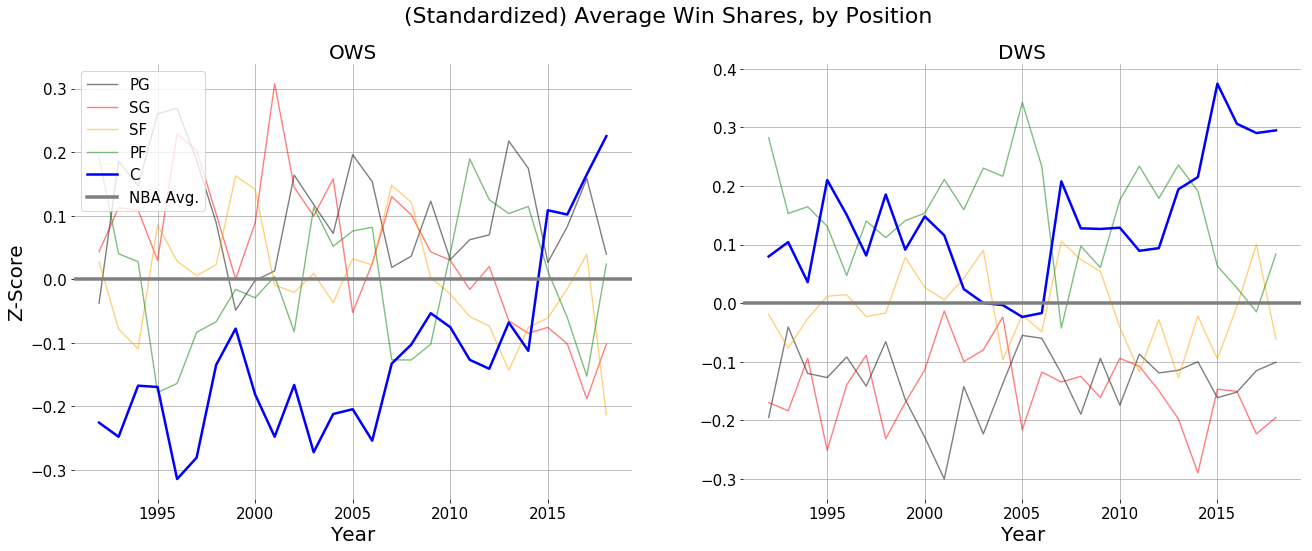

In [28]:
# Standardize Salaries by Year, Re-Run Mean Plot

dict_list = []

# Start at 1992 because salary data not available before 1985, and not in 1987
for year in range(1992, np.max(players_df.Year)+1):
    
    # Standardize OWS, DWS, WS, WS_Per_48
    year_query = players_df[players_df['Year']==year]

    year_query['OWS'] = (year_query['OWS']-np.mean(year_query['OWS']))/np.std(year_query['OWS'])
    year_query['DWS'] = (year_query['DWS']-np.mean(year_query['DWS']))/np.std(year_query['DWS'])
    year_query['WS'] = (year_query['WS']-np.mean(year_query['WS']))/np.std(year_query['WS'])
    year_query['WS_Per_48'] = (year_query['WS_Per_48']-np.mean(year_query['WS_Per_48']))/np.std(year_query['WS_Per_48'])

    
    for pos in players_df.Pos.unique():
        
        # Query by Position, by Year
        query = year_query[year_query['Pos']==pos]
        
        # Aggregate Height, Experience, Salary
        mean_ows = np.mean(query['OWS'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_dws = np.mean(query['DWS'])
        mean_ws = np.mean(query['WS'])
        mean_ws_per_48 = np.mean(query['WS_Per_48'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_OWS': mean_ows, 'Mean_DWS': mean_dws, 'Mean_WS': mean_ws, 'Mean_WS_Per_48': mean_ws_per_48}
        
        dict_list.append(d)
        
ws_by_year = pd.DataFrame(data=dict_list)

# Plot it!

fig, axes = plt.subplots(1,2, figsize=(22,8))

colors = ['black', 'red', 'orange', 'green', 'blue']
alphas = [0.5, 0.5, 0.5, 0.5, 1.0]
linewidths = [1.4, 1.4, 1.4, 1.4, 2.5]

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    axes[0].plot(ws_by_year[ws_by_year['Pos']==pos].Year, ws_by_year[ws_by_year['Pos']==pos].Mean_OWS, color=colors[i], alpha=alphas[i], linewidth=linewidths[i], label=pos)
    
for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    axes[1].plot(ws_by_year[ws_by_year['Pos']==pos].Year, ws_by_year[ws_by_year['Pos']==pos].Mean_DWS, color=colors[i], alpha=alphas[i], linewidth=linewidths[i], label=pos)    

#axes[1].set_ylim([])
    
axes[0].axhline(y=0, color='grey', linewidth=3.5, label='NBA Avg.')
axes[1].axhline(y=0, color='grey', linewidth=3.5, label='NBA Avg.')

axes[0].set_xlabel('Year', fontsize=20)
axes[0].set_ylabel('Z-Score', fontsize=20)
axes[0].set_title('OWS', fontsize=20)

axes[1].set_xlabel('Year', fontsize=20)
axes[1].set_title('DWS', fontsize=20)

fig.suptitle('(Standardized) Average Win Shares, by Position', fontsize=22)

axes[0].xaxis.set_tick_params(labelsize=15)
axes[0].yaxis.set_tick_params(labelsize=15)
axes[1].xaxis.set_tick_params(labelsize=15)
axes[1].yaxis.set_tick_params(labelsize=15)
    
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)    

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)    

axes[0].legend(prop={'size': 15}, loc='upper left')
#axes[1].legend(prop={'size': 15})
axes[0].grid()
axes[1].grid()
#plt.savefig('OWS_DWS_Standardized.png')
plt.show()

C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

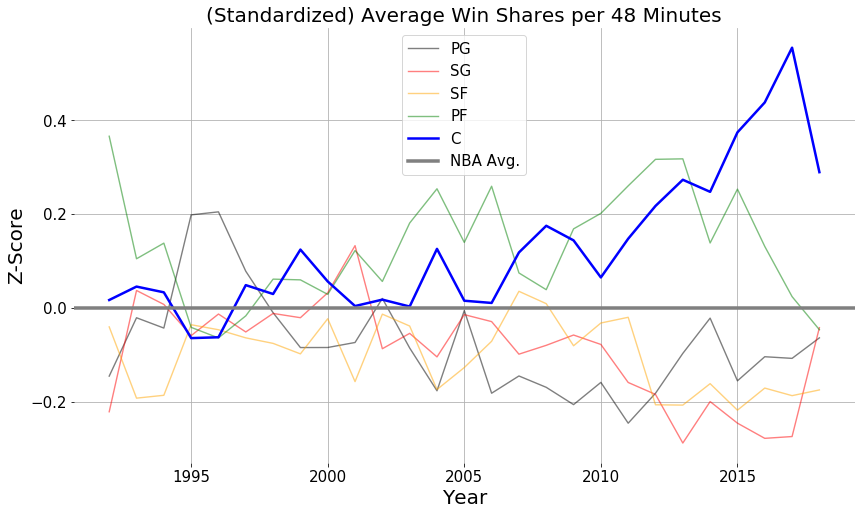

In [26]:
# Standardize Salaries by Year, Re-Run Mean Plot

dict_list = []

# Start at 1992 because salary data not available before 1985, and not in 1987
for year in range(1992, np.max(players_df.Year)+1):
    
    # Standardize OWS, DWS, WS, WS_Per_48
    year_query = players_df[players_df['Year']==year]

    year_query['OWS'] = (year_query['OWS']-np.mean(year_query['OWS']))/np.std(year_query['OWS'])
    year_query['DWS'] = (year_query['DWS']-np.mean(year_query['DWS']))/np.std(year_query['DWS'])
    year_query['WS'] = (year_query['WS']-np.mean(year_query['WS']))/np.std(year_query['WS'])
    year_query['WS_Per_48'] = (year_query['WS_Per_48']-np.mean(year_query['WS_Per_48']))/np.std(year_query['WS_Per_48'])

    
    for pos in players_df.Pos.unique():
        
        # Query by Position, by Year
        query = year_query[year_query['Pos']==pos]
        
        # Aggregate Height, Experience, Salary
        mean_ows = np.mean(query['OWS'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_dws = np.mean(query['DWS'])
        mean_ws = np.mean(query['WS'])
        mean_ws_per_48 = np.mean(query['WS_Per_48'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_OWS': mean_ows, 'Mean_DWS': mean_dws, 'Mean_WS': mean_ws, 'Mean_WS_Per_48': mean_ws_per_48}
        
        dict_list.append(d)
        
ws_by_year = pd.DataFrame(data=dict_list)

# Plot it!

fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']
alphas = [0.5, 0.5, 0.5, 0.5, 1.0]
linewidths = [1.4, 1.4, 1.4, 1.4, 2.5]

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(ws_by_year[ws_by_year['Pos']==pos].Year, ws_by_year[ws_by_year['Pos']==pos].Mean_WS_Per_48, color=colors[i], alpha=alphas[i], linewidth=linewidths[i], label=pos) 
    
ax.axhline(y=0, color='grey', linewidth=3.5, label='NBA Avg.')

ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Z-Score', fontsize=20)
ax.set_title('(Standardized) Average Win Shares per 48 Minutes', fontsize=20)

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)       

ax.legend(prop={'size': 15})#, loc='upper left')
ax.grid()
plt.savefig('WS_per_48_Standardized.png')
plt.show()

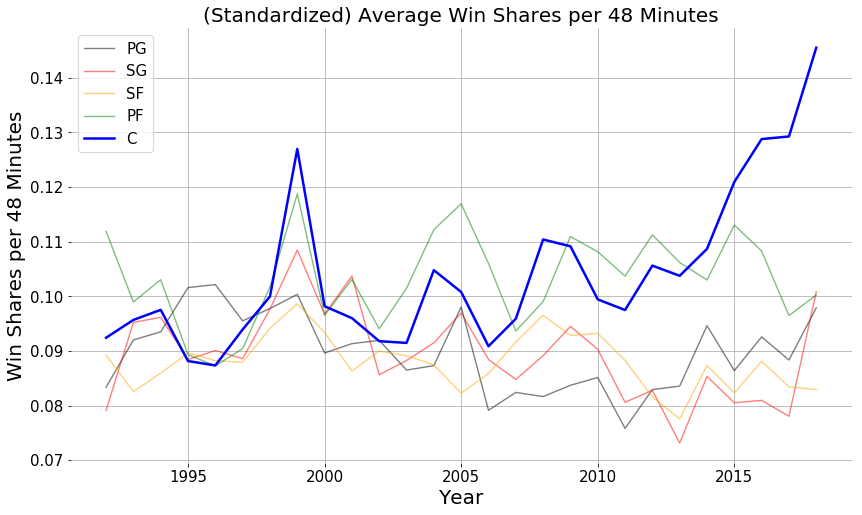

In [27]:
# Standardize Salaries by Year, Re-Run Mean Plot

dict_list = []

# Start at 1992 because salary data not available before 1985, and not in 1987
for year in range(1992, np.max(players_df.Year)+1):
    
    # Get Year Data
    year_query = players_df[players_df['Year']==year]
    
    for pos in players_df.Pos.unique():
        
        # Query by Position, by Year
        query = year_query[year_query['Pos']==pos]
        
        # Aggregate Height, Experience, Salary
        mean_ows = np.mean(query['OWS'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_dws = np.mean(query['DWS'])
        mean_ws = np.mean(query['WS'])
        mean_ws_per_48 = np.mean(query['WS_Per_48'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_OWS': mean_ows, 'Mean_DWS': mean_dws, 'Mean_WS': mean_ws, 'Mean_WS_Per_48': mean_ws_per_48}
        
        dict_list.append(d)
        
ws_by_year = pd.DataFrame(data=dict_list)

# Plot it!

fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']
alphas = [0.5, 0.5, 0.5, 0.5, 1.0]
linewidths = [1.4, 1.4, 1.4, 1.4, 2.5]

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(ws_by_year[ws_by_year['Pos']==pos].Year, ws_by_year[ws_by_year['Pos']==pos].Mean_WS_Per_48, color=colors[i], alpha=alphas[i], linewidth=linewidths[i], label=pos) 

ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Win Shares per 48 Minutes', fontsize=20)
ax.set_title('(Standardized) Average Win Shares per 48 Minutes', fontsize=20)

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)       

ax.legend(prop={'size': 15})#, loc='upper left')
ax.grid()
plt.savefig('WS_per_48_Standardized.png')
plt.show()

In [28]:
# Test P-Val of WS_Per_48 of Centers vs. Non-Centers
centers_2018 = players_df[np.logical_and(players_df['Pos']=='C', players_df['Year']==2018)]
non_centers_2018 = players_df[np.logical_and(players_df['Pos']!='C', players_df['Year']==2018)]

sp.stats.ttest_ind(centers_2018['WS_Per_48'], non_centers_2018['WS_Per_48'])

Ttest_indResult(statistic=3.333718004658345, pvalue=0.00092143199891255002)

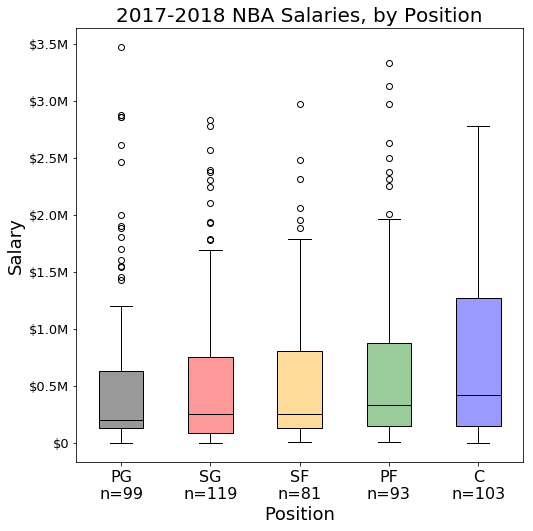

In [29]:
# Make Boxplot of 2018 Salaries
players_2018 = players_df[players_df['Year']==2018]
pg = players_2018[players_2018['Pos']=='PG'].Salary
sg = players_2018[players_2018['Pos']=='SG'].Salary
sf = players_2018[players_2018['Pos']=='SF'].Salary
pf = players_2018[players_2018['Pos']=='PF'].Salary
c = players_2018[players_2018['Pos']=='C'].Salary

pos_list = [pg, sg, sf, pf, c]

fig, ax = plt.subplots(1,1,figsize=(8,8))

bp = ax.boxplot(pos_list, patch_artist=True)

ax.set_xlabel('Position', fontsize=18)
ax.set_ylabel('Salary', fontsize=18)
ax.set_title('2017-2018 NBA Salaries, by Position', fontsize=20)

xlabels = ['PG\nn={}'.format(len(pg)),
           'SG\nn={}'.format(len(sg)),
           'SF\nn={}'.format(len(sf)),
           'PF\nn={}'.format(len(pf)),
           'C\nn={}'.format(len(c))]
ax.set_xticklabels(xlabels, fontsize=16)

ylabels = ['', '$0', '$0.5M', '$1.0M', '$1.5M', '$2.0M', '$2.5M', '$3.0M', '$3.5M']
ax.set_yticklabels(ylabels, fontsize=13)

# fill with colors
colors = ['black', 'red', 'orange', 'green', 'blue']
for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))
    
for element in ['medians']:
    plt.setp(bp[element], color='black', linewidth=1)

plt.savefig('Salary_Boxplot.png')
plt.show()

In [30]:
print('Mean Salary among Centers:', np.mean(c))
non_centers_2018 = players_df[np.logical_and(players_df['Pos']!='C', players_df['Year']==2018)]
print('Mean Salary among Non-Centers:', np.mean(non_centers_2018.Salary))

Mean Salary among Centers: 7742447.8737864075
Mean Salary among Non-Centers: 6003583.510204081


# Repeat Analyses with Just Top 10 Players
### Combatting Selection Bias

In [41]:
# Repeat Some Analyses with Just Top 10 Players
dict_list = []

# Start at 1988 because salary data not available before 1985, and not in 1987
for year in range(1992, np.max(top_roster_df.Year)+1):
    for pos in top_roster_df.Pos.unique():
        
        # Query by Psotion, by Year
        query = top_roster_df[np.logical_and(top_roster_df['Year']==year, top_roster_df['Pos']==pos)]
        
        # Aggregate Height, Experience, Salary
        mean_ht = np.mean(query['Height'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_sal = np.mean(query['Salary'])
        mean_exp = np.mean(query['Exp'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_Height': mean_ht, 'Mean_Exp': mean_exp, 'Mean_Salary': mean_sal}
        
        dict_list.append(d)
        
sal_by_year = pd.DataFrame(data=dict_list)
sal_by_year.head()

,Mean_Exp,Mean_Height,Mean_Salary,Pos,Year
0,4.629630,79.314815,1.085130e+06,SF,1992
1,4.049180,81.180328,1.140754e+06,PF,1992
2,5.345455,83.818182,1.343782e+06,C,1992
3,4.440000,76.800000,1.001940e+06,SG,1992
4,4.140000,73.160000,9.967000e+05,PG,1992


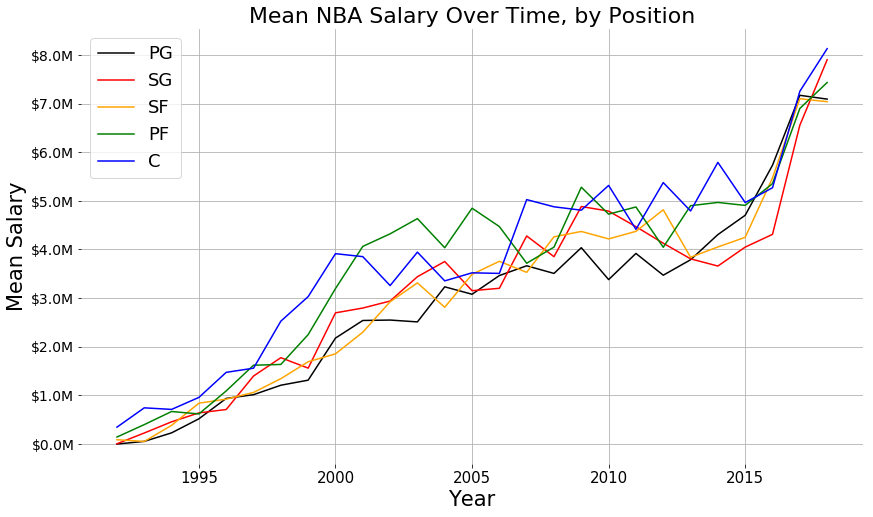

In [42]:
fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(sal_by_year[sal_by_year['Pos']==pos].Year, sal_by_year[sal_by_year['Pos']==pos].Mean_Salary, color=colors[i], label=pos)
    
ax.set_xlabel('Year', fontsize=21)
ax.set_ylabel('Mean Salary', fontsize=21)
ax.set_title('Mean NBA Salary Over Time, by Position', fontsize=22)

labels = ['$' + str(n) + '.0M' for n in range(-1,9)]
ax.set_yticklabels(labels)

plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)    

ax.legend(prop={'size': 18})
plt.grid()
#plt.savefig('MeanSalaries.png')
plt.show()

In [43]:
#### How big is the difference betweeen Centers' salaries and guards? ####

# Standardize Salaries by Year, Re-Run Mean Plot

dict_list = []

# Start at 1988 because salary data not available before 1985, and not in 1987
for year in range(1992, np.max(top_roster_df.Year)+1):
    
    # Standardize Height, Salaries
    year_query = top_roster_df[top_roster_df['Year']==year]

    year_query['Salary'] = (year_query['Salary']-np.mean(year_query['Salary']))/np.std(year_query['Salary'])
    year_query['Height'] = (year_query['Height']-np.mean(year_query['Height']))/np.std(year_query['Height'])
    
    for pos in top_roster_df.Pos.unique():
        
        # Query by Position, by Year
        query = year_query[year_query['Pos']==pos]
        
        # Aggregate Height, Experience, Salary
        mean_ht = np.mean(query['Height'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_sal = np.mean(query['Salary'])
        mean_exp = np.mean(query['Exp'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_Height': mean_ht, 'Mean_Exp': mean_exp, 'Mean_Salary': mean_sal}
        
        dict_list.append(d)
        
sal_by_year = pd.DataFrame(data=dict_list)
sal_by_year.head()

C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Mean_Exp,Mean_Height,Mean_Salary,Pos,Year
0,4.629630,0.066479,-0.040234,SF,1992
1,4.049180,0.531548,0.026624,PF,1992
2,5.345455,1.189158,0.270652,C,1992
3,4.440000,-0.560458,-0.140223,SG,1992
4,4.140000,-1.467902,-0.146522,PG,1992


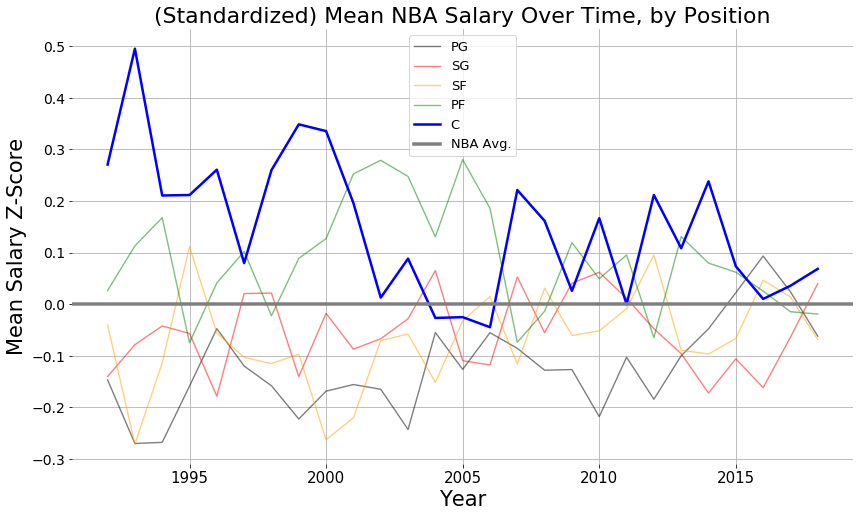

In [44]:
fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']
alphas = [0.5, 0.5, 0.5, 0.5, 1.0]
linewidths = [1.4, 1.4, 1.4, 1.4, 2.5]

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(sal_by_year[sal_by_year['Pos']==pos].Year, sal_by_year[sal_by_year['Pos']==pos].Mean_Salary, color=colors[i], alpha=alphas[i], linewidth=linewidths[i], label=pos)
    
ax.axhline(y=0, color='grey', linewidth=3.5, label='NBA Avg.')

ax.set_xlabel('Year', fontsize=21)
ax.set_ylabel('Mean Salary Z-Score', fontsize=21)
ax.set_title('(Standardized) Mean NBA Salary Over Time, by Position', fontsize=22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=14)    

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)    

ax.legend(prop={'size': 13}, loc='upper center')
plt.grid()
plt.savefig('MeanSalariesStandardized_Adjusted.png')
plt.show()

In [35]:
# Get P-Values for 2018:
centers_2018 = top_roster_df[np.logical_and(top_roster_df['Pos']=='C', top_roster_df['Year']==2018)]
non_centers_2018 = top_roster_df[np.logical_and(top_roster_df['Pos']!='C', top_roster_df['Year']==2018)]

print('Average Experience of Centers (in years):', np.mean(centers_2018['Exp']))
print('Average Experience of Non-Centers (in years):', np.mean(non_centers_2018['Exp']))

sp.stats.ttest_ind(centers_2018['Salary'], non_centers_2018['Salary'])

Average Experience of Centers (in years): 5.602739726027397
Average Experience of Non-Centers (in years): 5.136563876651983


Ttest_indResult(statistic=0.67293747511512969, pvalue=0.50150857012086492)

C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

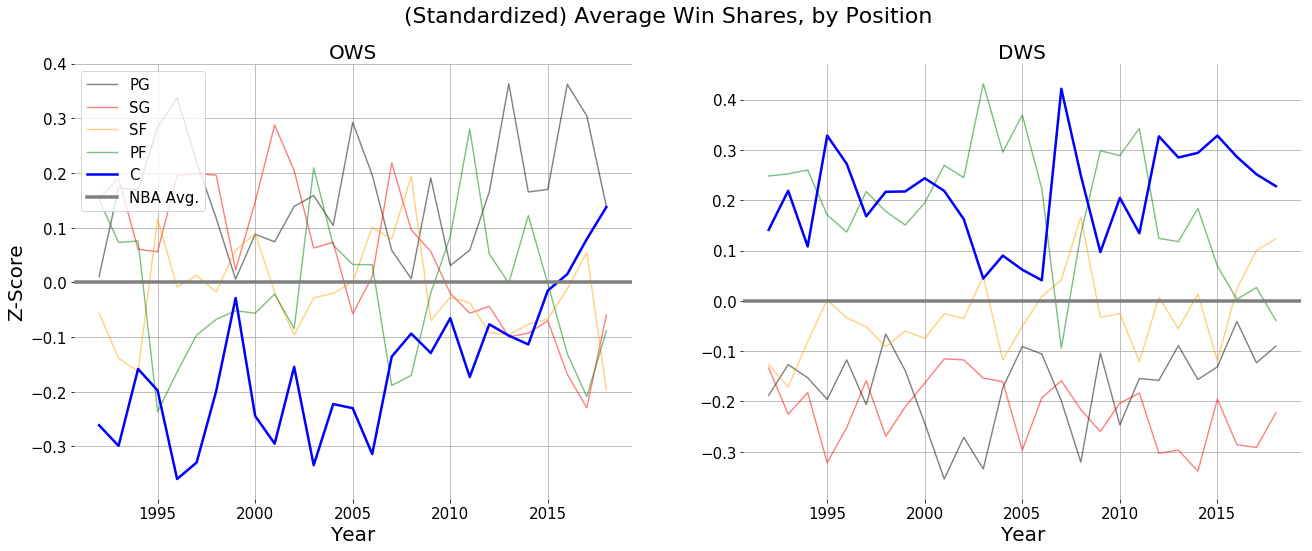

In [29]:
# Standardize Salaries by Year, Re-Run Mean Plot

dict_list = []

# Start at 1992 because salary data not available before 1985, and not in 1987
for year in range(1992, np.max(top_roster_df.Year)+1):
    
    # Standardize OWS, DWS, WS, WS_Per_48
    year_query = top_roster_df[top_roster_df['Year']==year]

    year_query['OWS'] = (year_query['OWS']-np.mean(year_query['OWS']))/np.std(year_query['OWS'])
    year_query['DWS'] = (year_query['DWS']-np.mean(year_query['DWS']))/np.std(year_query['DWS'])
    year_query['WS'] = (year_query['WS']-np.mean(year_query['WS']))/np.std(year_query['WS'])
    year_query['WS_Per_48'] = (year_query['WS_Per_48']-np.mean(year_query['WS_Per_48']))/np.std(year_query['WS_Per_48'])

    
    for pos in top_roster_df.Pos.unique():
        
        # Query by Position, by Year
        query = year_query[year_query['Pos']==pos]
        
        # Aggregate Height, Experience, Salary
        mean_ows = np.mean(query['OWS'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_dws = np.mean(query['DWS'])
        mean_ws = np.mean(query['WS'])
        mean_ws_per_48 = np.mean(query['WS_Per_48'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_OWS': mean_ows, 'Mean_DWS': mean_dws, 'Mean_WS': mean_ws, 'Mean_WS_Per_48': mean_ws_per_48}
        
        dict_list.append(d)
        
ws_by_year = pd.DataFrame(data=dict_list)

# Plot it!

fig, axes = plt.subplots(1,2, figsize=(22,8))

colors = ['black', 'red', 'orange', 'green', 'blue']
alphas = [0.5, 0.5, 0.5, 0.5, 1.0]
linewidths = [1.4, 1.4, 1.4, 1.4, 2.5]

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    axes[0].plot(ws_by_year[ws_by_year['Pos']==pos].Year, ws_by_year[ws_by_year['Pos']==pos].Mean_OWS, color=colors[i], alpha=alphas[i], linewidth=linewidths[i], label=pos)
    
for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    axes[1].plot(ws_by_year[ws_by_year['Pos']==pos].Year, ws_by_year[ws_by_year['Pos']==pos].Mean_DWS, color=colors[i], alpha=alphas[i], linewidth=linewidths[i], label=pos)    

#axes[1].set_ylim([])
    
axes[0].axhline(y=0, color='grey', linewidth=3.5, label='NBA Avg.')
axes[1].axhline(y=0, color='grey', linewidth=3.5, label='NBA Avg.')

axes[0].set_xlabel('Year', fontsize=20)
axes[0].set_ylabel('Z-Score', fontsize=20)
axes[0].set_title('OWS', fontsize=20)

axes[1].set_xlabel('Year', fontsize=20)
axes[1].set_title('DWS', fontsize=20)

fig.suptitle('(Standardized) Average Win Shares, by Position', fontsize=22)

axes[0].xaxis.set_tick_params(labelsize=15)
axes[0].yaxis.set_tick_params(labelsize=15)
axes[1].xaxis.set_tick_params(labelsize=15)
axes[1].yaxis.set_tick_params(labelsize=15)
    
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)    

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)    

axes[0].legend(prop={'size': 15}, loc='upper left')
#axes[1].legend(prop={'size': 15})
axes[0].grid()
axes[1].grid()
plt.savefig('OWS_DWS_Standardized_Adjusted.png')
plt.show()

C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

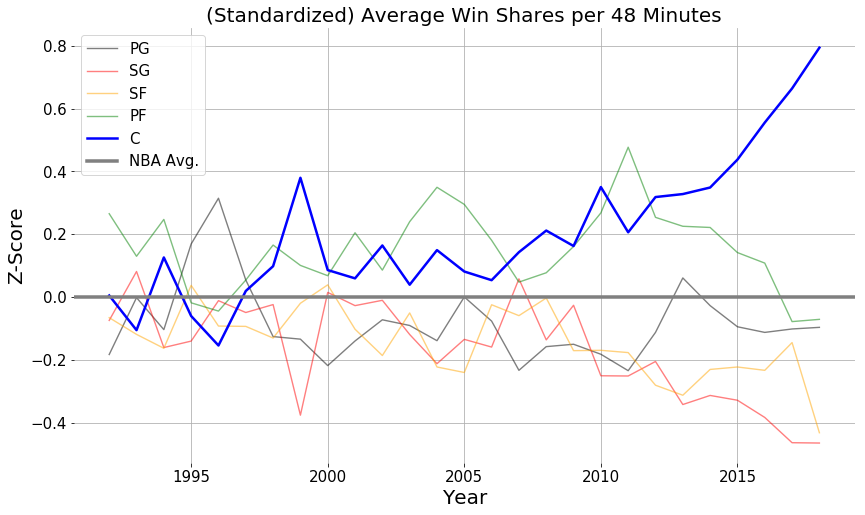

In [30]:
# Standardize Salaries by Year, Re-Run Mean Plot

dict_list = []

# Start at 1992 because salary data not available before 1985, and not in 1987
for year in range(1992, np.max(top_roster_df.Year)+1):
    
    # Standardize OWS, DWS, WS, WS_Per_48
    year_query = top_roster_df[top_roster_df['Year']==year]

    year_query['OWS'] = (year_query['OWS']-np.mean(year_query['OWS']))/np.std(year_query['OWS'])
    year_query['DWS'] = (year_query['DWS']-np.mean(year_query['DWS']))/np.std(year_query['DWS'])
    year_query['WS'] = (year_query['WS']-np.mean(year_query['WS']))/np.std(year_query['WS'])
    year_query['WS_Per_48'] = (year_query['WS_Per_48']-np.mean(year_query['WS_Per_48']))/np.std(year_query['WS_Per_48'])

    
    for pos in top_roster_df.Pos.unique():
        
        # Query by Position, by Year
        query = year_query[year_query['Pos']==pos]
        
        # Aggregate Height, Experience, Salary
        mean_ows = np.mean(query['OWS'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_dws = np.mean(query['DWS'])
        mean_ws = np.mean(query['WS'])
        mean_ws_per_48 = np.mean(query['WS_Per_48'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_OWS': mean_ows, 'Mean_DWS': mean_dws, 'Mean_WS': mean_ws, 'Mean_WS_Per_48': mean_ws_per_48}
        
        dict_list.append(d)
        
ws_by_year = pd.DataFrame(data=dict_list)

# Plot it!

fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']
alphas = [0.5, 0.5, 0.5, 0.5, 1.0]
linewidths = [1.4, 1.4, 1.4, 1.4, 2.5]

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(ws_by_year[ws_by_year['Pos']==pos].Year, ws_by_year[ws_by_year['Pos']==pos].Mean_WS_Per_48, color=colors[i], alpha=alphas[i], linewidth=linewidths[i], label=pos) 
    
ax.axhline(y=0, color='grey', linewidth=3.5, label='NBA Avg.')

ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Z-Score', fontsize=20)
ax.set_title('(Standardized) Average Win Shares per 48 Minutes', fontsize=20)

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)       

ax.legend(prop={'size': 15})#, loc='upper left')
ax.grid()
plt.savefig('WS_per_48_Standardized_Adjusted.png')
plt.show()

In [41]:
print('Mean WS/48 of Centers in 2018:', np.mean(top_roster_df[np.logical_and(top_roster_df['Pos'] == 'C', top_roster_df['Year']==2018)].WS_Per_48))
print('Mean WS/48 of PFs in 2018:', np.mean(top_roster_df[np.logical_and(top_roster_df['Pos'] == 'PF', top_roster_df['Year']==2018)].WS_Per_48))

# Test P-Val of WS_Per_48 of Centers vs. Non-Centers
centers_2018 = top_roster_df[np.logical_and(top_roster_df['Pos']=='C', top_roster_df['Year']==2018)]
non_centers_2018 = top_roster_df[np.logical_and(top_roster_df['Pos']!='C', top_roster_df['Year']==2018)]

sp.stats.ttest_ind(centers_2018['WS_Per_48'], non_centers_2018['WS_Per_48'])

Mean WS/48 of Centers in 2018: 0.15223287671232877
Mean WS/48 of PFs in 2018: 0.10610769230769229


Ttest_indResult(statistic=8.7041089596978907, pvalue=2.2240872006109968e-16)

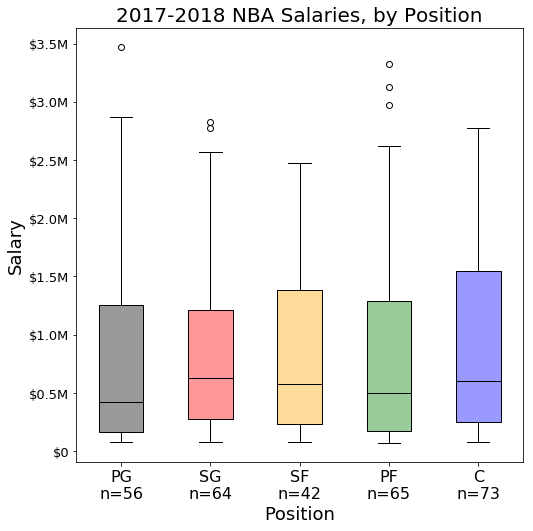

In [38]:
# Make Boxplot of 2018 Salaries
players_2018 = top_roster_df[top_roster_df['Year']==2018]
pg = players_2018[players_2018['Pos']=='PG'].Salary
sg = players_2018[players_2018['Pos']=='SG'].Salary
sf = players_2018[players_2018['Pos']=='SF'].Salary
pf = players_2018[players_2018['Pos']=='PF'].Salary
c = players_2018[players_2018['Pos']=='C'].Salary

pos_list = [pg, sg, sf, pf, c]

fig, ax = plt.subplots(1,1,figsize=(8,8))

bp = ax.boxplot(pos_list, patch_artist=True)

ax.set_xlabel('Position', fontsize=18)
ax.set_ylabel('Salary', fontsize=18)
ax.set_title('2017-2018 NBA Salaries, by Position', fontsize=20)

xlabels = ['PG\nn={}'.format(len(pg)),
           'SG\nn={}'.format(len(sg)),
           'SF\nn={}'.format(len(sf)),
           'PF\nn={}'.format(len(pf)),
           'C\nn={}'.format(len(c))]
ax.set_xticklabels(xlabels, fontsize=16)

ylabels = ['', '$0', '$0.5M', '$1.0M', '$1.5M', '$2.0M', '$2.5M', '$3.0M', '$3.5M']
ax.set_yticklabels(ylabels, fontsize=13)

# fill with colors
colors = ['black', 'red', 'orange', 'green', 'blue']
for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))
    
for element in ['medians']:
    plt.setp(bp[element], color='black', linewidth=1)

#plt.savefig('Salary_Boxplot.png')
plt.show()

C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

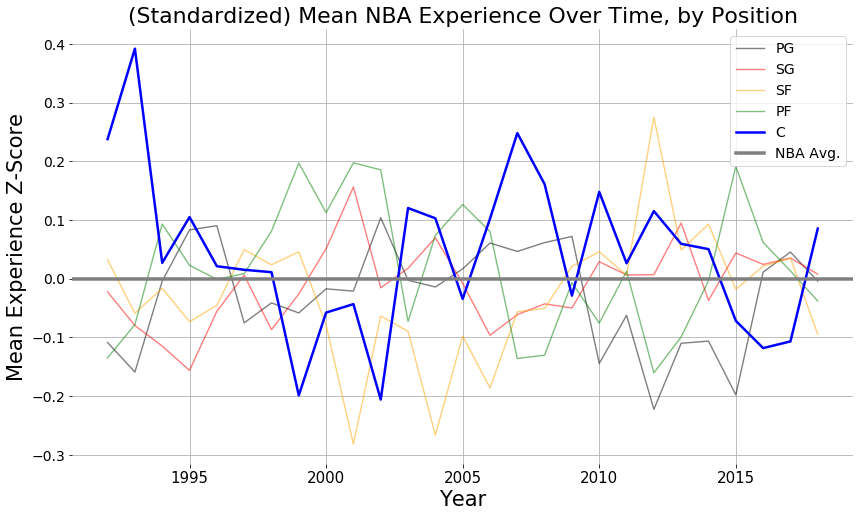

In [46]:
# Standardize Salaries by Year, Re-Run Mean Plot

dict_list = []

# Start at 1988 because salary data not available before 1985, and not in 1987
for year in range(1992, np.max(top_roster_df.Year)+1):
    
    # Standardize Height, Salaries
    year_query = top_roster_df[top_roster_df['Year']==year]

    year_query['Salary'] = (year_query['Salary']-np.mean(year_query['Salary']))/np.std(year_query['Salary'])
    year_query['Height'] = (year_query['Height']-np.mean(year_query['Height']))/np.std(year_query['Height'])
    year_query['Exp'] = (year_query['Exp']-np.mean(year_query['Exp']))/np.std(year_query['Exp'])
    
    for pos in players_df.Pos.unique():
        
        # Query by Position, by Year
        query = year_query[year_query['Pos']==pos]
        
        # Aggregate Height, Experience, Salary
        mean_ht = np.mean(query['Height'])
        #mean_sal = query[['Salary']].quantile(0.75)
        mean_sal = np.mean(query['Salary'])
        mean_exp = np.mean(query['Exp'])
        
        # Dictionary for One Entry7
        d = {'Pos': pos, 'Year': year, 'Mean_Height': mean_ht, 'Mean_Exp': mean_exp, 'Mean_Salary': mean_sal}
        
        dict_list.append(d)
        
sal_by_year = pd.DataFrame(data=dict_list)

# Plot it!

fig, ax = plt.subplots(1,1, figsize=(14,8))

colors = ['black', 'red', 'orange', 'green', 'blue']
alphas = [0.5, 0.5, 0.5, 0.5, 1.0]
linewidths = [1.4, 1.4, 1.4, 1.4, 2.5]

for i, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C']):
    ax.plot(sal_by_year[sal_by_year['Pos']==pos].Year, sal_by_year[sal_by_year['Pos']==pos].Mean_Exp, color=colors[i], alpha=alphas[i], linewidth=linewidths[i], label=pos)
    
ax.axhline(y=0, color='grey', linewidth=3.5, label='NBA Avg.')

ax.set_xlabel('Year', fontsize=21)
ax.set_ylabel('Mean Experience Z-Score', fontsize=21)
ax.set_title('(Standardized) Mean NBA Experience Over Time, by Position', fontsize=22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)    

ax.legend(prop={'size': 14})
plt.grid()
plt.savefig('MeanExpStandardized_Adjusted.png')
plt.show()